In [1]:
# import libraries

from tqdm import tqdm

from astropy.visualization import simple_norm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pickle as pkl


from wavelets_pytorch.wavelets import DOG
from wavelets_pytorch.transform import WaveletTransformTorch

# from tqdm import tqdm

import datetime
datecode = '{}-{}-{}'.format(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day)

interim_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/interim/'
processed_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/processed/'
raw_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/raw/'
external_dir = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/external/'

# make new folders in interim and processed directories for today's date

if os.path.join(interim_dir, datecode) not in [x[0] for x in os.walk(interim_dir)]:
    os.mkdir(os.path.join(interim_dir, datecode))
if os.path.join(processed_dir, datecode) not in [x[0] for x in os.walk(processed_dir)]:
    os.mkdir(os.path.join(processed_dir, datecode))

print(datecode)

2022-6-28


In [78]:
# Function to extract column headers from dfn file via Mnyikka https://stackoverflow.com/questions/3368969/find-string-between-two-substrings

def GetListOfSubstrings(stringSubject,string1,string2):
    MyList = []
    intstart=0
    strlength=len(stringSubject)
    continueloop = 1

    while(intstart < strlength and continueloop == 1):
        intindex1=stringSubject.find(string1,intstart)
        if(intindex1 != -1): #The substring was found, lets proceed
            intindex1 = intindex1+len(string1)
            intindex2 = stringSubject.find(string2,intindex1)
            if(intindex2 != -1):
                subsequence=stringSubject[intindex1:intindex2]
                MyList.append(subsequence)
                intstart=intindex2+len(string2)
            else:
                continueloop=0
        else:
            continueloop=0
    return MyList

# Create colour map for timegates

import pylab
NUM_COLORS = 15

cm = pylab.get_cmap('plasma')
color_list = []
for i in range(NUM_COLORS):
    color = cm(i/NUM_COLORS)  # color will now be an RGBA tuple
    color_list.append(color)

In [86]:
QLD_EM_dat_fn = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/raw/Final_QLD_Regional_lines/located_data/AusAEM_Year1_QLD_Final_EM.dat'
QLD_EM_dfn_fn = '/mnt/c/Projects/Blogs/AusAEM_blog_TS/data/raw/Final_QLD_Regional_lines/located_data/AusAEM_Year1_QLD_Final_EM.dfn'

with open(QLD_EM_dfn_fn, 'r') as file:
    QLD_EM_dfn = file.read()

column_names = GetListOfSubstrings(QLD_EM_dfn, 'RT=;', ':')
column_names_list = []
for header in column_names:
    if header.startswith('EM'):
        column_names_list = column_names_list + [header + '[{}]'.format(i) for i in range(1,16)]
    else:
        column_names_list.append(header)

EMZ_HPRG_list = ['EMZ_HPRG' + '[{}]'.format(i) for i in range(1,16)]

QLD_EM = pd.read_csv(QLD_EM_dat_fn, header = None, delim_whitespace=True, nrows = 1)
QLD_EM.columns = column_names_list

select_cols = ['Line', 'Easting', 'Northing'] + EMZ_HPRG_list
col_index = []
for item in select_cols:
    col_index.append(QLD_EM.columns.get_loc(item))

QLD_EM = pd.read_csv(QLD_EM_dat_fn, header = None, delim_whitespace=True, usecols = col_index, na_values=-999.999999)

QLD_EM.columns = select_cols
QLD_EM = QLD_EM.dropna()

In [88]:
# Create along-line distance field

append_here = np.array([])
for line in tqdm(QLD_EM.Line.unique()):
    data = QLD_EM[QLD_EM.Line == line].sort_values('Easting')
    array = np.zeros_like(data)
    array = array[:,0]
    for i in range(len(data)):
        if i == 0:
            array[i] = 0
        else:
            array[i] = array[i-1] + np.sqrt(np.abs((data['Easting'].iloc[i] - data['Easting'].iloc[i-1]))**2 + np.abs((data['Northing'].iloc[i] - data['Northing'].iloc[i-1]))**2)
    append_here=  np.append(append_here, array)
QLD_EM['line_distance'] = append_here

100%|██████████| 159/159 [00:56<00:00,  2.82it/s]


In [93]:
dxar = np.empty(len(QLD_EM))
for i in tqdm(range(len(QLD_EM))):
     dxar[i] = QLD_EM.iloc[i+1]['line_distance'] - QLD_EM.iloc[i]['line_distance']

100%|█████████▉| 2156905/2156906 [05:21<00:00, 6702.36it/s]


IndexError: single positional indexer is out-of-bounds

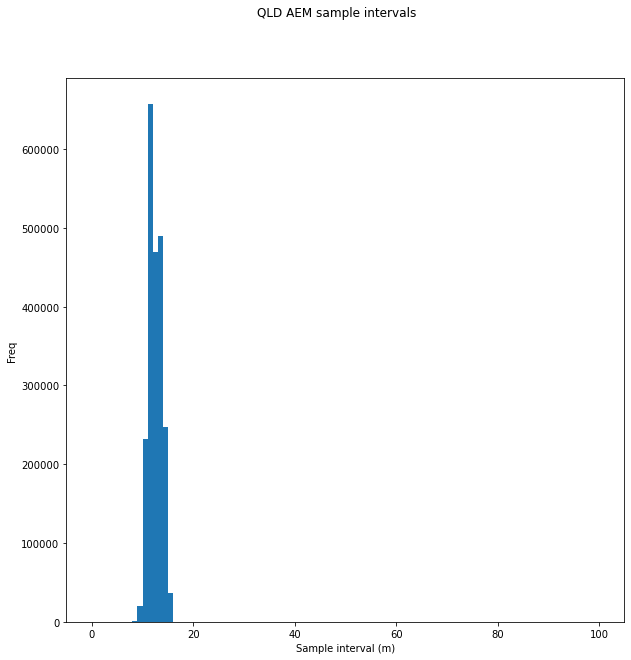

In [118]:
fig, ax = plt.subplots(figsize = (10,10))

ax.hist(np.abs(dxar[np.abs(dxar)<100]), bins = 100)
ax.set(xlabel = 'Sample interval (m)', ylabel = 'Freq')
fig.suptitle('QLD AEM sample intervals')

plt.show()

In [131]:
# Resample data to consistent 20 m interval

x_interval = 20 # m
x_interp = np.array([])
EMZ_HPRG_interp = []
E_interp = []
N_interp = []
line_list = np.array([])
for line in tqdm(QLD_EM.Line.unique()):
    data = QLD_EM[QLD_EM.Line == line]
    x = QLD_EM[QLD_EM.Line == line]['line_distance']
    y = data[EMZ_HPRG_list].values.T
    x = data['line_distance']
    E = data['Easting']
    N = data['Northing']
    newx = np.arange(0,x.max(), x_interval)
    line_ar = np.full(newx.shape, line)
    line_list = np.append(line_list, line_ar)

    x_interp = np.append(x_interp, newx)
    new_E = np.interp(newx, x, E)
    E_interp.append(new_E)

    new_N = np.interp(newx, x, N)
    N_interp.append(new_N)

    new_EMZ_HPRG = interp_along_axis(y, x, newx)
    EMZ_HPRG_interp.append(new_EMZ_HPRG)

EMZ_HPRG_interp_ar = np.concatenate(EMZ_HPRG_interp, axis =1)
new_E_ar = np.concatenate(E_interp)
new_N_ar = np.concatenate(N_interp)

  0%|          | 0/159 [00:00<?, ?it/s]/home/taschaap/miniconda3/envs/datascience_37/lib/python3.7/site-packages/ipykernel_launcher.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/taschaap/miniconda3/envs/datascience_37/lib/python3.7/site-packages/ipykernel_launcher.py:99: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/taschaap/miniconda3/envs/datascience_37/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instea

In [164]:
# Generate dataframe 

QLD_interp = pd.DataFrame()
QLD_interp['x'] = x_interp
QLD_interp['Line'] = line_list.astype(int)
QLD_interp['E'] = new_E_ar
QLD_interp['N'] = new_N_ar
QLD_interp[EMZ_HPRG_list] = pd.DataFrame(EMZ_HPRG_interp_ar.T)
QLD_interp = QLD_interp.dropna()

In [165]:
QLD_interp

,x,Line,E,N,EMZ_HPRG[1],EMZ_HPRG[2],EMZ_HPRG[3],EMZ_HPRG[4],EMZ_HPRG[5],EMZ_HPRG[6],EMZ_HPRG[7],EMZ_HPRG[8],EMZ_HPRG[9],EMZ_HPRG[10],EMZ_HPRG[11],EMZ_HPRG[12],EMZ_HPRG[13],EMZ_HPRG[14],EMZ_HPRG[15]
1,20.0,2001001,838379.503397,8.228496e+06,3.917205,1.704265,1.173887,0.695785,0.411339,0.225238,0.116533,0.062548,0.033610,0.020464,0.011709,0.010638,0.007622,0.003552,0.001752
2,40.0,2001001,838359.885485,8.228497e+06,4.032521,1.737314,1.191728,0.707598,0.418931,0.229467,0.119582,0.064334,0.033852,0.020204,0.012216,0.011210,0.007577,0.003793,0.001909
3,60.0,2001001,838340.239512,8.228498e+06,4.121922,1.767844,1.205877,0.716701,0.424274,0.231588,0.120756,0.064894,0.033989,0.020120,0.012819,0.011932,0.007622,0.004113,0.002067
4,80.0,2001001,838320.592982,8.228500e+06,4.185286,1.796022,1.216467,0.723160,0.428010,0.232488,0.120862,0.064827,0.034138,0.020458,0.013388,0.012599,0.007596,0.004490,0.002231
5,100.0,2001001,838300.932186,8.228501e+06,4.228033,1.822717,1.223635,0.726939,0.430002,0.232569,0.120265,0.064583,0.034458,0.021175,0.013696,0.013005,0.007367,0.004795,0.002368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537193,9900.0,91917901,477536.120151,7.989599e+06,7.972043,7.461290,7.120763,6.685358,6.174468,5.569549,4.865692,4.118819,3.375022,2.646454,1.952998,1.343414,0.846659,0.476033,0.192660
1537194,9920.0,91917901,477516.518258,7.989598e+06,8.051130,7.541971,7.193144,6.744346,6.224488,5.604905,4.886906,4.128259,3.374956,2.640008,1.942937,1.333907,0.838383,0.468217,0.186718
1537195,9940.0,91917901,477496.977311,7.989598e+06,8.083376,7.580502,7.228155,6.770702,6.243750,5.614033,4.886647,4.122221,3.365104,2.627936,1.931269,1.324127,0.829621,0.460465,0.180184
1537196,9960.0,91917901,477477.443319,7.989598e+06,8.056049,7.564724,7.212929,6.755991,6.225786,5.593465,4.863648,4.100897,3.346382,2.611591,1.919142,1.314069,0.820030,0.452681,0.173149


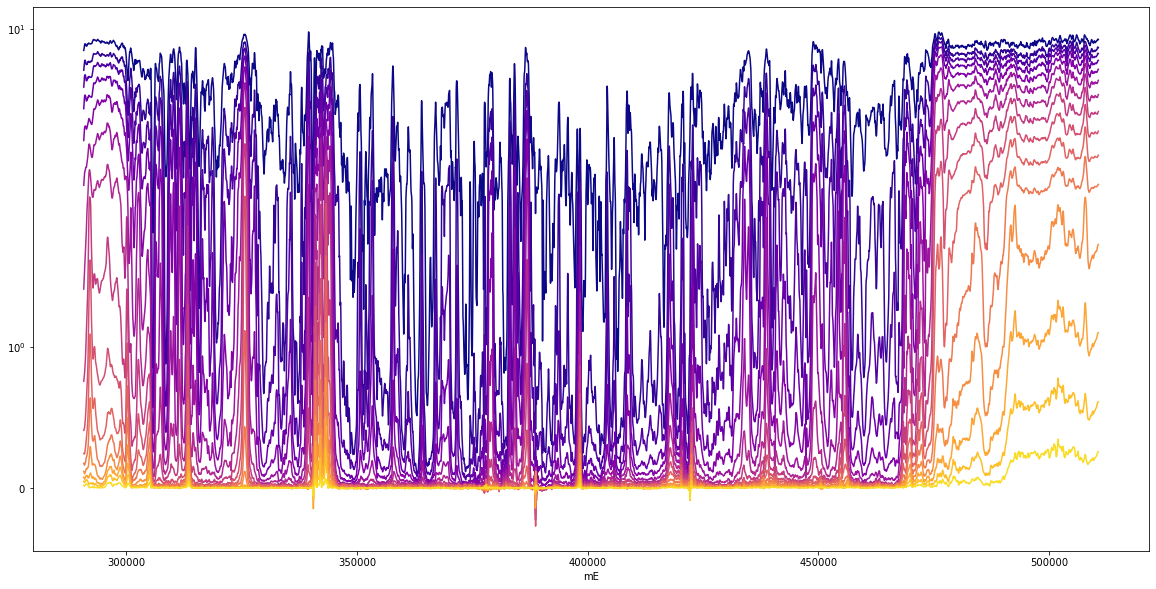

In [149]:
fig, ax = plt.subplots(figsize = (20,10))

line = 2032002

for i in range(1,16):
    ax.plot(QLD_interp[QLD_interp.Line == line]['E'], QLD_interp[QLD_interp.Line == line][EMZ_HPRG_list[i-1]], color = color_list[i-1])
ax.set(yscale = 'symlog', xlabel = 'mE')

plt.show()

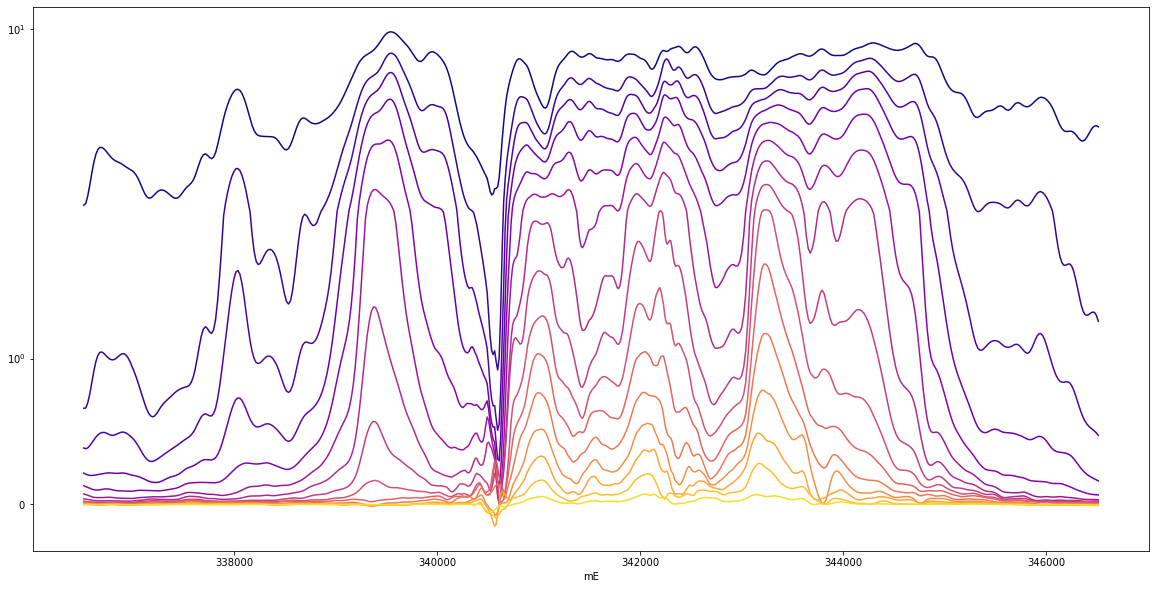

In [156]:
fig, ax = plt.subplots(figsize = (20,10))

line = 2032002

for i in range(1,16):
    ax.plot(QLD_interp[(QLD_interp.Line == line) & (QLD_interp.E > 341512.1-5000) & (QLD_interp.E < 341512.1+5000)]['E'], QLD_interp[(QLD_interp.Line == line) & (QLD_interp.E > 341512.1-5000) & (QLD_interp.E < 341512.1+5000)][EMZ_HPRG_list[i-1]], color = color_list[i-1])
ax.set(yscale = 'symlog', xlabel = 'mE')

plt.show()

In [166]:
EMZ_HPRG_norm_list = [title + '_norm' for title in EMZ_HPRG_list]

for timegate in range(len(EMZ_HPRG_list)):
    min = QLD_interp[EMZ_HPRG_list[timegate]].min()
    max = QLD_interp[EMZ_HPRG_list[timegate]].max()
    QLD_interp[EMZ_HPRG_norm_list[timegate]] = (QLD_interp[EMZ_HPRG_list[timegate]] - min) / (max - min)

In [167]:
QLD_interp

,x,Line,E,N,EMZ_HPRG[1],EMZ_HPRG[2],EMZ_HPRG[3],EMZ_HPRG[4],EMZ_HPRG[5],EMZ_HPRG[6],...,EMZ_HPRG[6]_norm,EMZ_HPRG[7]_norm,EMZ_HPRG[8]_norm,EMZ_HPRG[9]_norm,EMZ_HPRG[10]_norm,EMZ_HPRG[11]_norm,EMZ_HPRG[12]_norm,EMZ_HPRG[13]_norm,EMZ_HPRG[14]_norm,EMZ_HPRG[15]_norm
1,20.0,2001001,838379.503397,8.228496e+06,3.917205,1.704265,1.173887,0.695785,0.411339,0.225238,...,0.033026,0.037889,0.029865,0.039877,0.022103,0.018780,0.021889,0.044612,0.094654,0.177375
2,40.0,2001001,838359.885485,8.228497e+06,4.032521,1.737314,1.191728,0.707598,0.418931,0.229467,...,0.033476,0.038225,0.030079,0.039909,0.022064,0.018868,0.022012,0.044599,0.094758,0.177507
3,60.0,2001001,838340.239512,8.228498e+06,4.121922,1.767844,1.205877,0.716701,0.424274,0.231588,...,0.033702,0.038355,0.030145,0.039927,0.022051,0.018974,0.022168,0.044612,0.094896,0.177639
4,80.0,2001001,838320.592982,8.228500e+06,4.185286,1.796022,1.216467,0.723160,0.428010,0.232488,...,0.033797,0.038367,0.030137,0.039946,0.022102,0.019073,0.022313,0.044604,0.095059,0.177776
5,100.0,2001001,838300.932186,8.228501e+06,4.228033,1.822717,1.223635,0.726939,0.430002,0.232569,...,0.033806,0.038301,0.030108,0.039988,0.022209,0.019127,0.022400,0.044539,0.095190,0.177892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537193,9900.0,91917901,477536.120151,7.989599e+06,7.972043,7.461290,7.120763,6.685358,6.174468,5.569549,...,0.601433,0.562053,0.513987,0.477369,0.413903,0.357316,0.309974,0.284773,0.298309,0.337390
1537194,9920.0,91917901,477516.518258,7.989598e+06,8.051130,7.541971,7.193144,6.744346,6.224488,5.604905,...,0.605193,0.564394,0.515114,0.477360,0.412941,0.355562,0.307919,0.282404,0.294940,0.332410
1537195,9940.0,91917901,477496.977311,7.989598e+06,8.083376,7.580502,7.228155,6.770702,6.243750,5.614033,...,0.606164,0.564365,0.514393,0.476070,0.411140,0.353527,0.305806,0.279896,0.291599,0.326933
1537196,9960.0,91917901,477477.443319,7.989598e+06,8.056049,7.564724,7.212929,6.755991,6.225786,5.593465,...,0.603977,0.561827,0.511848,0.473619,0.408701,0.351412,0.303631,0.277151,0.288244,0.321036


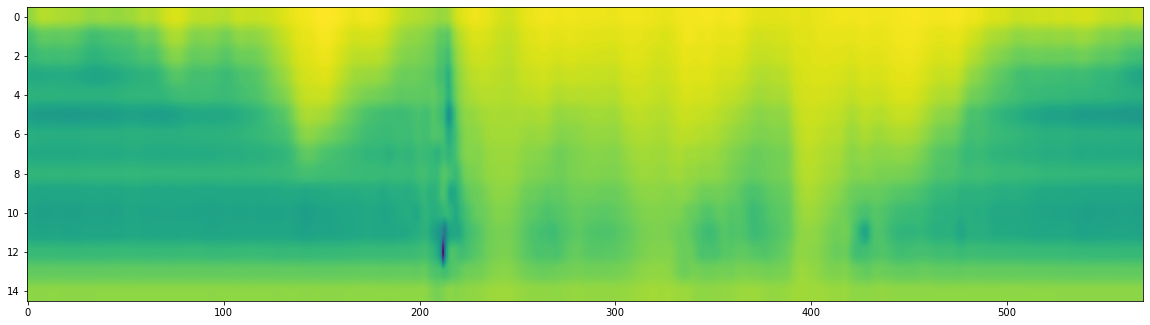

In [179]:
fig, ax = plt.subplots(figsize = (20,10))

line = 2032002

ax.imshow(np.log10(QLD_interp[(QLD_interp.Line == line) & (QLD_interp.E > 341512.1-5000) & (QLD_interp.E < 341512.1+5000)][EMZ_HPRG_norm_list].T+0.0001), aspect = 10)

plt.show()

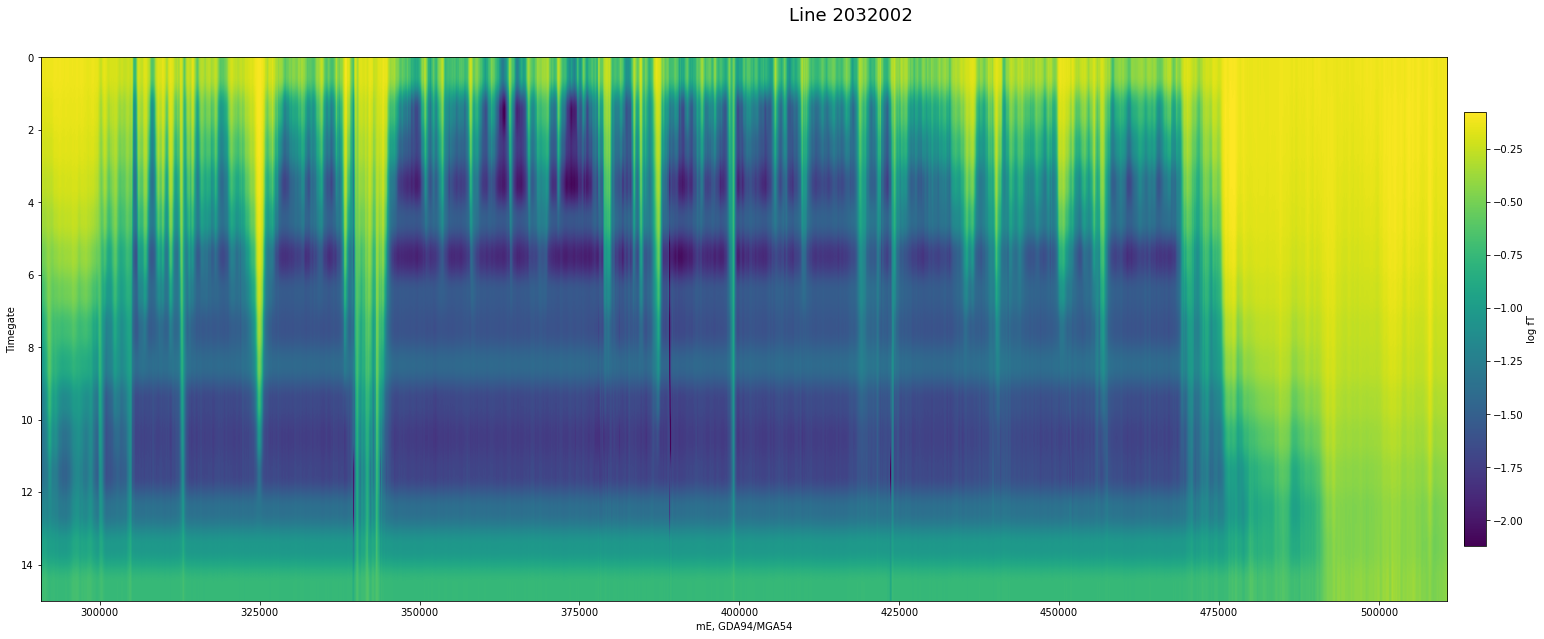

In [213]:
fig, ax = plt.subplots(figsize = (30,10))

line = 2032002

norm = simple_norm(np.log10(QLD_interp[(QLD_interp.Line == line)][EMZ_HPRG_norm_list].T+0.0001), percent = 99.95)
im = ax.imshow(np.log10(QLD_interp[(QLD_interp.Line == line)][EMZ_HPRG_norm_list].T+0.0001), aspect = 'auto', extent = (QLD_interp[(QLD_interp.Line == line)].E.min(), QLD_interp[(QLD_interp.Line == line)].E.max(), 15, 0), norm = norm)
ax.set(xlabel = 'mE, GDA94/MGA54', ylabel = 'Timegate')
fig.suptitle('Line ' + str(line), fontsize = 18, y = 0.95)
fig.colorbar(im, shrink = 0.8, pad = 0.01, label = 'log fT')

plt.show()

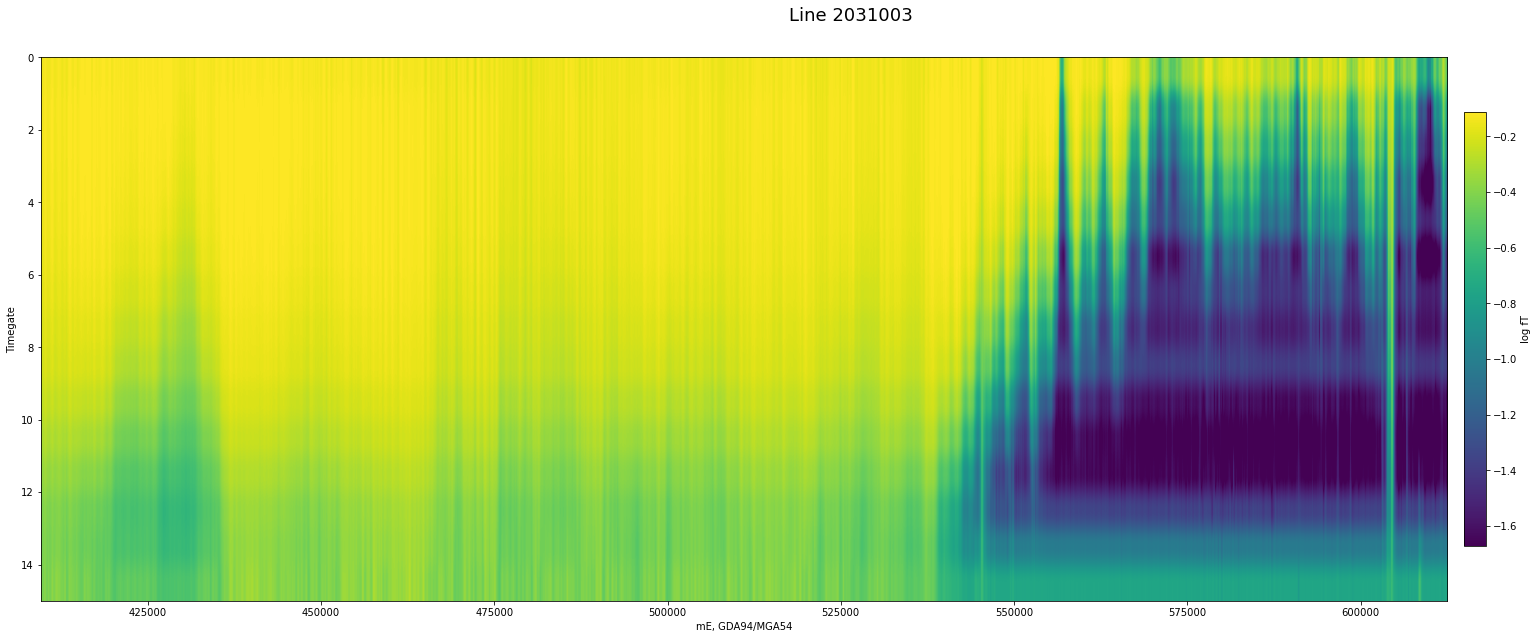

In [215]:
fig, ax = plt.subplots(figsize = (30,10))

line = 2031003

norm = simple_norm(np.log10(QLD_interp[(QLD_interp.Line == line)][EMZ_HPRG_norm_list].T+0.0001), percent = 95)
im = ax.imshow(np.log10(QLD_interp[(QLD_interp.Line == line)][EMZ_HPRG_norm_list].T+0.0001), aspect = 'auto', extent = (QLD_interp[(QLD_interp.Line == line)].E.min(), QLD_interp[(QLD_interp.Line == line)].E.max(), 15, 0), norm = norm)
ax.set(xlabel = 'mE, GDA94/MGA54', ylabel = 'Timegate')
fig.suptitle('Line ' + str(line), fontsize = 18, y = 0.95)
fig.colorbar(im, shrink = 0.8, pad = 0.01, label = 'log fT')

plt.show()

In [119]:
def interp_along_axis(y, x, newx, axis=1, inverse=False, method='linear'):
    """ Interpolate vertical profiles, e.g. of atmospheric variables
    using vectorized numpy operations

    This function assumes that the x-xoordinate increases monotonically

    #### EDIT BY ####
    Thomas Schaap
    February 2022
    * Updated to take 1Darray for input x and newx
    * Updated to 'axis' default = 1, probably breaks if specified otherwise

    ps:
    * Updated to work with irregularly spaced x-coordinate.
    * Updated to work with irregularly spaced newx-coordinate
    * Updated to easily inverse the direction of the x-coordinate
    * Updated to fill with nans outside extrapolation range
    * Updated to include a linear interpolation method as well
        (it was initially written for a cubic function)

    Peter Kalverla
    March 2018

    --------------------
    More info:
    Algorithm from: http://www.paulinternet.nl/?page=bicubic
    It approximates y = f(x) = ax^3 + bx^2 + cx + d
    where y may be an ndarray input vector
    Returns f(newx)

    The algorithm uses the derivative f'(x) = 3ax^2 + 2bx + c
    and uses the fact that:
    f(0) = d
    f(1) = a + b + c + d
    f'(0) = c
    f'(1) = 3a + 2b + c

    Rewriting this yields expressions for a, b, c, d:
    a = 2f(0) - 2f(1) + f'(0) + f'(1)
    b = -3f(0) + 3f(1) - 2f'(0) - f'(1)
    c = f'(0)
    d = f(0)

    These can be evaluated at two neighbouring points in x and
    as such constitute the piecewise cubic interpolator.
    """

    x = np.array([np.array(x) for i in np.empty(y.shape[0])])

    newx = np.array([np.array(newx) for i in np.empty(y.shape[0])])

    # View of x and y with axis as first dimension
    if inverse:
        _x = np.moveaxis(x, axis, 0)[::-1, ...]
        _y = np.moveaxis(y, axis, 0)[::-1, ...]
        _newx = np.moveaxis(newx, axis, 0)[::-1, ...]
    else:
        _y = np.moveaxis(y, axis, 0)
        _x = np.moveaxis(x, axis, 0)
        _newx = np.moveaxis(newx, axis, 0)

    if np.any(np.diff(_x, axis=0) < 0):
        raise ValueError('x should increase monotonically')
    if np.any(np.diff(_newx, axis=0) < 0):
        raise ValueError('newx should increase monotonically')

    # Cubic interpolation needs the gradient of y in addition to its values
    if method == 'cubic':
        # For now, simply use a numpy function to get the derivatives
        # This produces the largest memory overhead of the function and
        # could alternatively be done in passing.
        ydx = np.gradient(_y, axis=0, edge_order=2)

    # This will later be concatenated with a dynamic '0th' index
    ind = [i for i in np.indices(_y.shape[1:])]

    # Allocate the output array
    original_dims = _y.shape
    newdims = list(original_dims)
    newdims[0] = len(_newx)
    newy = np.zeros(newdims)

    # set initial bounds
    i_lower = np.zeros(_x.shape[1:], dtype=int)
    i_upper = np.ones(_x.shape[1:], dtype=int)
    x_lower = _x[0, ...]
    x_upper = _x[1, ...]

    for i, xi in enumerate(_newx):
        # Start at the 'bottom' of the array and work upwards
        # This only works if x and newx increase monotonically

        # Update bounds where necessary and possible
        needs_update = (xi > x_upper) & (i_upper+1<len(_x))
        # print x_upper.max(), np.any(needs_update)
        while np.any(needs_update):
            i_lower = np.where(needs_update, i_lower+1, i_lower)
            i_upper = i_lower + 1
            x_lower = _x[[i_lower]+ind]
            x_upper = _x[[i_upper]+ind]

            # Check again
            needs_update = (xi > x_upper) & (i_upper+1<len(_x))

        # Express the position of xi relative to its neighbours
        xj = (xi-x_lower)/(x_upper - x_lower)

        # Determine where there is a valid interpolation range
        within_bounds = (_x[0, ...] < xi) & (xi < _x[-1, ...])

        if method == 'linear':
            f0, f1 = _y[[i_lower]+ind], _y[[i_upper]+ind]
            a = f1 - f0
            b = f0

            newy[i, ...] = np.where(within_bounds, a*xj+b, np.nan)

        elif method=='cubic':
            f0, f1 = _y[[i_lower]+ind], _y[[i_upper]+ind]
            df0, df1 = ydx[[i_lower]+ind], ydx[[i_upper]+ind]

            a = 2*f0 - 2*f1 + df0 + df1
            b = -3*f0 + 3*f1 - 2*df0 - df1
            c = df0
            d = f0

            newy[i, ...] = np.where(within_bounds, a*xj**3 + b*xj**2 + c*xj + d, np.nan)

        else:
            raise ValueError("invalid interpolation method"
                             "(choose 'linear' or 'cubic')")

    if inverse:
        newy = newy[::-1, ...]

    return np.moveaxis(newy, 0, axis)